In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import re
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import requests

/usr/lib/python3/dist-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.4.0) or chardet (5.1.0)/charset_normalizer (3.0.1) doesn't match a supported version!
  warnings.warn(


In [140]:
def clean_name(name):
    # Remove common suffixes (case-insensitive)
    name = re.sub(r"\s+(Jr\.?|Sr\.?|II|III|IV|V)$", "", name, flags=re.IGNORECASE)
    return name.strip()


def extract_pos_rank(pos_string):
    #gets the position rank # out of something like QB7
    
    if isinstance(pos_string, str):
        match = re.search(r"\d+", pos_string)
        return int(match.group()) if match else None
    return None

In [173]:
#read in the entry draft and rookie draft csv files
entry_draft = pd.read_csv('entry_draft.csv')
rookie_draft = pd.read_csv('rookie_draft.csv')

#condense name into one column
entry_draft['player_name'] = entry_draft['first_name']+' '+entry_draft['last_name']
del entry_draft['first_name'],entry_draft['last_name'],entry_draft['team'],entry_draft['Unnamed: 0']

rookie_draft['player_name'] = rookie_draft['first_name']+' '+rookie_draft['last_name']
del rookie_draft['first_name'],rookie_draft['last_name'],rookie_draft['team'],rookie_draft['Unnamed: 0']

#read in the pre-season and current rankings from fantasypros
fp_rankings_2024 = pd.read_csv('fantasypros_2024_rankings.csv')
fp_rankings_2025 = pd.read_csv('fantasypros_2025_rankings.csv')

#remove team abbreviation i.e. Josh Allen (BUF)
fp_rankings_2024['Player Name'] = fp_rankings_2024['Player'].str.replace(r"\s*\(.*\)", "", regex=True)
fp_rankings_2025['Player Name'] = fp_rankings_2025['Player Name'].str.replace(r"\s*\(.*\)", "", regex=True)

#clean the player names so they match in each list
entry_draft["clean_player_name"] = entry_draft["player_name"].apply(clean_name)
rookie_draft["clean_player_name"] = rookie_draft["player_name"].apply(clean_name)
fp_rankings_2024["clean_player_name"] = fp_rankings_2024["Player"].apply(clean_name)
fp_rankings_2025["clean_player_name"] = fp_rankings_2025["Player Name"].apply(clean_name)

#get the position rank of each player in its own column
fp_rankings_2024["pre_pos_rank"] = fp_rankings_2024["POS"].apply(extract_pos_rank)
fp_rankings_2025["post_pos_rank"] = fp_rankings_2025["POS"].apply(extract_pos_rank)
# Rename column for clean merge
fp_rankings_2024.rename(columns={"clean_player_name": "player_name", "Rank": "pre_draft_rank"}, inplace=True)
fp_rankings_2025.rename(columns={"clean_player_name": "player_name", "RK": "post_draft_rank"}, inplace=True)

# Merge the pre-season rankings
entry_draft = entry_draft.merge(
    fp_rankings_2024[["player_name", "POS", "pre_pos_rank"]],
    on="player_name",
    how="left"
).rename(columns={"POS": "pre_POS"})

#merge the current rankings
entry_draft = entry_draft.merge(
    fp_rankings_2025[["player_name", "POS", "post_pos_rank"]],
    on="player_name",
    how="left"
).rename(columns={"POS": "post_POS"})

#calulate the ranking change
entry_draft["pos_rank_change"] =  entry_draft["pre_pos_rank"] - entry_draft["post_pos_rank"]

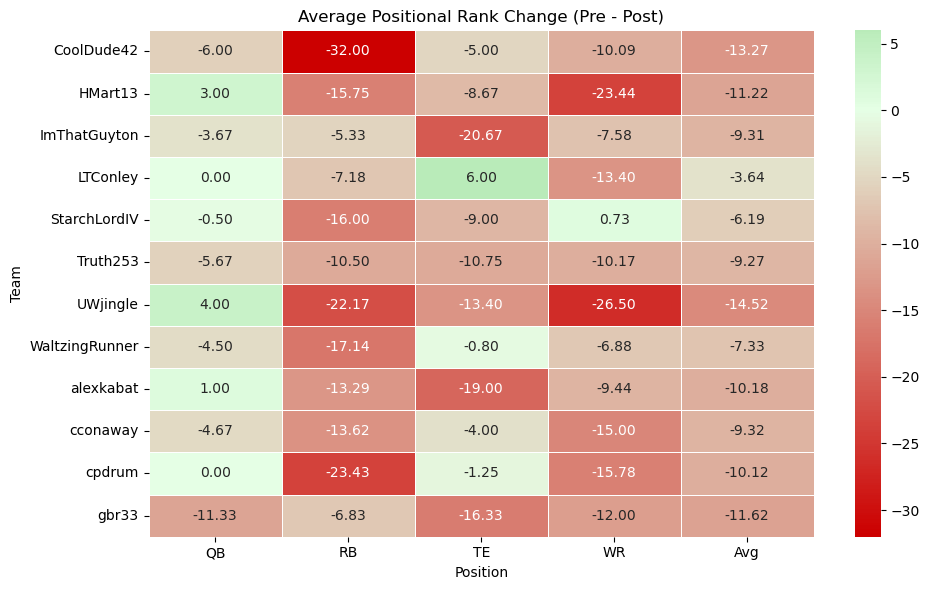

In [142]:
#makes a table of the average positional ranking changes for those drafted in the entry draft
position_grouped = (
    entry_draft
    .groupby(["owner_name", "position"])["pos_rank_change"]
    .mean()
    .reset_index()
    .rename(columns={"pos_rank_change": "avg_pos_rank_change"})
)

pivoted = position_grouped.pivot(index="owner_name", columns="position", values="avg_pos_rank_change")
pivoted = pivoted.fillna(0).round(2)  # Optional: replace NaN with 0 and round values
pivoted["Avg"] = pivoted.mean(axis=1).round(2)

# Custom diverging colormap: more green around zero
colors = [
    (0.8, 0.0, 0.0),   # red
    (0.9, 1.0, 0.9),   # pale green near zero
    (0.0, 0.6, 0.0)    # strong green
]
custom_cmap = LinearSegmentedColormap.from_list("custom_rdylgn", colors, N=256)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    pivoted, annot=True, cmap=custom_cmap, center=0,
    linewidths=0.5, fmt=".2f"
)
plt.title("Average Positional Rank Change (Pre - Post)")
plt.xlabel("Position")
plt.ylabel("Team")
plt.tight_layout()
plt.show()

In [289]:
league_id = "1184039966157762560"  # replace with your actual league ID

# Step 1: Get current rosters
rosters_url = f"https://api.sleeper.app/v1/league/{league_id}/rosters"
rosters_data = requests.get(rosters_url).json()

# Step 2: Get user info to map owner names
users_url = f"https://api.sleeper.app/v1/league/{league_id}/users"
users_data = requests.get(users_url).json()

# Step 3: Build user_id -> display_name mapping
user_map = {user["user_id"]: user["display_name"] for user in users_data}

# Step 4: Extract rosters and attach owner names
all_players = []
for roster in rosters_data:
    owner_id = roster["owner_id"]
    owner_name = user_map.get(owner_id, "Unknown")
    for player_id in roster["players"]:  # roster["players"] is a list of player_ids
        all_players.append({"owner": owner_name, "player_id": player_id})

# Convert to DataFrame
df_rosters = pd.DataFrame(all_players)
# Load the full player database
player_db_url = "https://api.sleeper.app/v1/players/nfl"
player_data = requests.get(player_db_url).json()

# Convert player_id to name/position
df_rosters["player_name"] = df_rosters["player_id"].apply(lambda pid: player_data[pid]["full_name"])
df_rosters["position"] = df_rosters["player_id"].apply(lambda pid: player_data[pid]["position"])

# merge the positional ranks from current rankings into the rosters dataframe
df_rosters = df_rosters.merge(
    fp_rankings_2025[["player_name","post_pos_rank"]],
    on=["player_name"],
    how="left"
)

#the position limits we will consider. The top 15 players per roster
position_limits = {
    "QB": 3,
    "RB": 4,
    "WR": 6,
    "TE": 2
}

ranked_rosters_current = pd.DataFrame(columns=['owner','QB','RB','WR','TE'])
ranked_rosters_current['owner'] = df_rosters['owner'].unique()


for owner in df_rosters['owner'].unique():
    temp = df_rosters[df_rosters['owner'] == owner].sort_values(by=["position", "post_pos_rank"])
    for pos in position_limits.items():
        top_players = temp[temp['position'] == pos[0]][:pos[1]]
        avg_rank = np.mean(top_players['post_pos_rank'])
        ranked_rosters_current.loc[ranked_rosters_current['owner']==owner,pos[0]] = round(avg_rank,1)

In [293]:
ranked_rosters_current

,owner,QB,RB,WR,TE
0,StarchLordIV,27.3,32.8,43.8,18.0
1,Truth253,20.3,35.0,41.3,12.5
2,ImThatGuyton,12.7,23.8,27.7,11.5
3,cconaway,25.0,13.8,47.7,18.5
4,WaltzingRunner,23.3,39.2,24.5,10.5
5,HMart13,4.0,21.5,40.2,19.0
6,cpdrum,14.0,25.0,26.7,6.0
7,LTConley,22.0,23.2,64.5,6.5
8,gbr33,21.7,20.5,42.5,29.0
9,UWjingle,19.3,19.5,58.8,24.5


In [296]:
entry_draft

,round,pick_no,position,owner_name,player_name,clean_player_name,pre_POS,pre_pos_rank,post_POS,post_pos_rank,pos_rank_change
0,1,1,QB,gbr33,Patrick Mahomes,Patrick Mahomes,QB1,1.0,QB6,6.0,-5.0
1,1,2,QB,ImThatGuyton,Josh Allen,Josh Allen,QB2,2.0,QB1,1.0,1.0
2,1,3,RB,UWjingle,Christian McCaffrey,Christian McCaffrey,RB2,2.0,RB17,17.0,-15.0
3,1,4,WR,LTConley,Amon-Ra St. Brown,Amon-Ra St. Brown,WR4,4.0,WR5,5.0,-1.0
4,1,5,QB,StarchLordIV,C.J. Stroud,C.J. Stroud,QB4,4.0,QB11,11.0,-7.0
...,...,...,...,...,...,...,...,...,...,...,...
331,28,332,RB,cconaway,Emani Bailey,Emani Bailey,NaN,NaN,NaN,NaN,NaN
332,28,333,RB,LTConley,Jase McClellan,Jase McClellan,NaN,NaN,NaN,NaN,NaN
333,28,334,TE,UWjingle,Tyler Higbee,Tyler Higbee,NaN,NaN,TE41,41.0,NaN
334,28,335,WR,ImThatGuyton,Calvin Austin,Calvin Austin,WR112,112.0,WR99,99.0,13.0


In [298]:
position_limits = {
    "QB": 3,
    "RB": 4,
    "WR": 6,
    "TE": 2
}

ranked_rosters_entry = pd.DataFrame(columns=['owner','QB','RB','WR','TE'])
ranked_rosters_entry['owner'] = entry_draft['owner_name'].unique()


for owner in entry_draft['owner_name'].unique():
    temp = entry_draft[entry_draft['owner_name'] == owner].sort_values(by=["position", "post_pos_rank"])
    for pos in position_limits.items():
        top_players = temp[temp['position'] == pos[0]][:pos[1]]
        avg_rank = np.mean(top_players['post_pos_rank'])
        ranked_rosters_entry.loc[ranked_rosters_entry['owner']==owner,pos[0]] = round(avg_rank,1)

In [299]:
ranked_rosters_entry

,owner,QB,RB,WR,TE
0,gbr33,23.0,30.5,41.8,31.0
1,ImThatGuyton,12.7,22.8,35.2,28.0
2,UWjingle,19.3,33.8,62.0,24.5
3,LTConley,22.5,23.2,63.8,6.5
4,StarchLordIV,18.7,58.7,29.8,18.0
5,HMart13,11.3,29.2,57.0,19.5
6,alexkabat,12.7,32.0,41.8,36.0
7,WaltzingRunner,27.7,26.2,33.3,10.5
8,cconaway,20.7,46.5,26.0,9.5
9,Truth253,23.0,27.8,57.8,13.0


In [313]:
#calculate the change in rankings from beginning to end of first season
delta_rankings = pd.DataFrame(columns = ranked_rosters_entry.columns)
delta_rankings['owner'] = ranked_rosters_entry['owner']

for owner in delta_rankings['owner']:
    for pos in delta_rankings.columns[1:]:
        delta = ranked_rosters_entry.loc[ranked_rosters_entry['owner']==owner,pos].values[0] - ranked_rosters_current.loc[ranked_rosters_current['owner']==owner,pos].values[0]
        delta_rankings.loc[delta_rankings['owner']==owner,pos] = delta

,owner,QB,RB,WR,TE
0,gbr33,1.3,10.0,-0.7,2.0
1,ImThatGuyton,0.0,-1.0,7.5,16.5
2,UWjingle,0.0,14.3,3.2,0.0
3,LTConley,0.5,0.0,-0.7,0.0
4,StarchLordIV,-8.6,25.9,-14.0,0.0
5,HMart13,7.3,7.7,16.8,0.5
6,alexkabat,0.0,3.5,18.5,6.5
7,WaltzingRunner,4.4,-13.0,8.8,0.0
8,cconaway,-4.3,32.7,-21.7,-9.0
9,Truth253,2.7,-7.2,16.5,0.5


In [ ]:
delta_rankings = delta_rankings.set_index('owner')

In [320]:
delta_rankings = delta_rankings.apply(pd.to_numeric, errors='coerce')
delta_rankings

,QB,RB,WR,TE
owner,,,,
gbr33,1.3,10.0,-0.7,2.0
ImThatGuyton,0.0,-1.0,7.5,16.5
UWjingle,0.0,14.3,3.2,0.0
LTConley,0.5,0.0,-0.7,0.0
StarchLordIV,-8.6,25.9,-14.0,0.0
HMart13,7.3,7.7,16.8,0.5
alexkabat,0.0,3.5,18.5,6.5
WaltzingRunner,4.4,-13.0,8.8,0.0
cconaway,-4.3,32.7,-21.7,-9.0


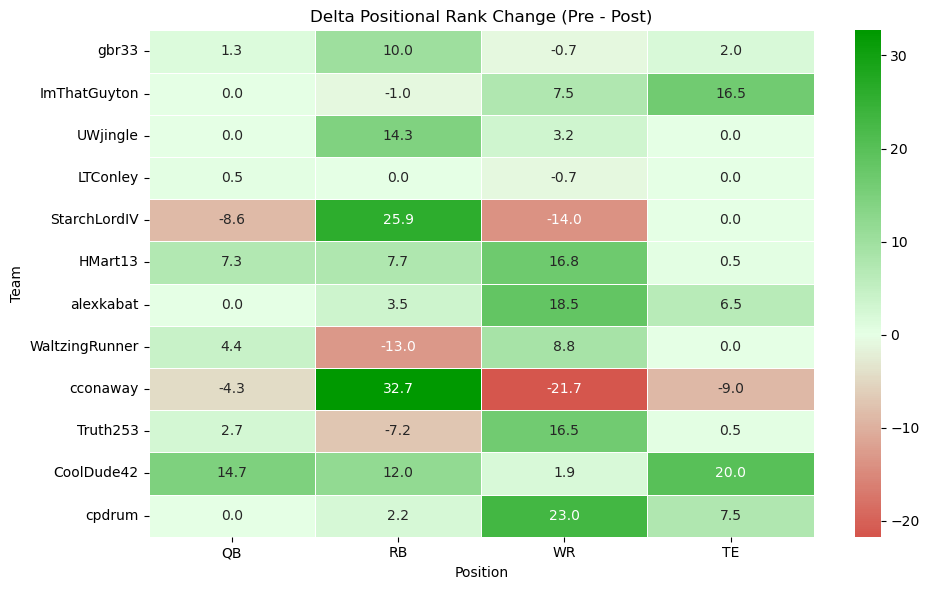

In [322]:
# Custom diverging colormap: more green around zero
colors = [
    (0.8, 0.0, 0.0),   # red
    (0.9, 1.0, 0.9),   # pale green near zero
    (0.0, 0.6, 0.0)    # strong green
]
custom_cmap = LinearSegmentedColormap.from_list("custom_rdylgn", colors, N=256)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    delta_rankings, annot=True, cmap=custom_cmap, center=0,
    linewidths=0.5, fmt=".1f"
)
plt.title("Delta Positional Rank Change (Pre - Post)")
plt.xlabel("Position")
plt.ylabel("Team")
plt.tight_layout()
plt.show()